In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.backend import squeeze
from tensorflow.keras.layers import Activation, BatchNormalization, Concatenate, Dropout, Input
from tensorflow.keras.layers import (
     Conv1D, Conv2D, Dense, MaxPooling2D, MaxPooling1D, AveragePooling2D, AveragePooling1D, Flatten, Reshape
)
from tensorflow.keras import optimizers

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

play_data = pd.read_csv('../data/plays.csv')
data = pd.read_csv('../ReducedData/BC_AllPlayers.csv')
train_tensor_field = np.zeros((len(data),11,10,9))
norm_stats = np.zeros((train_tensor_field.shape[-1],2))

### Create Training Labels

In [126]:
bounce_nf = ['Downed','Out of Bounds','Touchback']
data['Label'] = data['Type'].map({'Bounce':'No Field','Catch':'Field'})
data.loc[(data['Type']=='Bounce')&(~data['specialTeamsResult'].isin(bounce_nf)),'Label'] = 'Field'

punt_return = ['Return','Out of Bounds','Blocked Punt','Muffed']
punt_fc = ['Fair Catch','Downed']
data.loc[(data['Label']=='Field')&(data['specialTeamsResult'].isin(punt_return)),'Label'] = 'Return'
data.loc[(data['Label']=='Field')&(data['specialTeamsResult'].isin(punt_fc)),'Label'] = 'Fair Catch'

enc = OneHotEncoder()
labels = enc.fit_transform(data['Label'].values.reshape(-1,1)).toarray()

In [127]:
# OHE of the form [FC, NF, R]
# Modify some punts labelled 'Return'

expanded_data = data.merge(play_data[['gameId','playId','kickReturnYardage']])

# Returns with <= 0 Yard returns changed to [0.5, 0, 0.5]
neg_ret_id = expanded_data.loc[(expanded_data['Label']=='Return')&(expanded_data['kickReturnYardage']<=0)].index
labels[neg_ret_id] = [0.5, 0, 0.5]

# If kickReturnYardage isna, take the following three cases
# Muffed is questionable... > [0, 0.5, 0.5]
# Out of Bounds doesn't matter > [0.5, 0, 0.5]
# Return and Blocked are returns > [0, 0, 1]

oob_id = expanded_data.loc[(expanded_data['Label']=='Return')&(expanded_data['kickReturnYardage'].isna())&(expanded_data['specialTeamsResult']=='Out of Bounds')].index
muff_id = expanded_data.loc[(expanded_data['Label']=='Return')&(expanded_data['kickReturnYardage'].isna())&(expanded_data['specialTeamsResult']=='Muffed')].index

labels[oob_id] = [0.5, 0, 0.5]
#labels[muff_id] = [0, 0.5, 0.5]

#### Shuffle Punt Team and Return Team players

We do not shuffle the punter's location, since this will be part of the feature map, and the punter will not included on the Punt Team axis.

In [128]:
def shuffle_players(df):
    temp = np.concatenate((df.iloc[:,:-1:2].values[...,np.newaxis],df.iloc[:,1::2].values[...,np.newaxis]),axis=2)
    [np.random.shuffle(x) for x in temp]
    return pd.DataFrame(temp.reshape(temp.shape[0],-1),columns=df.columns)


data.iloc[:,5:25] = shuffle_players(data.iloc[:,5:25])
data.iloc[:,25:47] = shuffle_players(data.iloc[:,25:47])

#### Assign each team/role

In [129]:
fb_x = data.iloc[:,[47,49]]
fb_y = data.iloc[:,[48,50]]

punter = data.iloc[:,3:5]

punt_team_x = data.iloc[:,5:24:2]
punt_team_y = data.iloc[:,6:25:2]

ret_team_x = data.iloc[:,25:46:2]
ret_team_y = data.iloc[:,26:47:2]

### Create Tensor for Training Data

Features:

0,1) Difference in position (Punt Team - Return Team)_(x,y)

2,3) Difference in position (Punter - Return Team)_(x,y)

4,5) Difference in position (Football Landing - Return Team)_(x,y)

6,7) Position (Football Spot)_(x,y)

8) Hangtime of punt

In [130]:
def diff_coord(team1, team2):
    t1 = team1.stack().reset_index()
    t2 = team2.stack().reset_index()
    t1xt2 = t1.merge(t2,on='level_0')
    t1xt2['diff'] = t1xt2['0_y'] - t1xt2['0_x']
    return t1xt2.set_index(['level_0','level_1_y','level_1_x'])['diff']


# Find X and Y displacements for each combination of punt and return team players
train_tensor_field[:,:,:,0] = diff_coord(punt_team_x,ret_team_x).unstack().values.reshape(len(data),11,10)
train_tensor_field[:,:,:,1] = diff_coord(punt_team_y,ret_team_y).unstack().values.reshape(len(data),11,10)

# Find X and Y displacement between Punter and Return Team players
train_tensor_field[:,:,:,2] = np.tile((-ret_team_x.sub(punter['x_punt'],axis=0).values)[:,:,np.newaxis],10)
train_tensor_field[:,:,:,3] = np.tile((-ret_team_y.sub(punter['y_punt'],axis=0).values)[:,:,np.newaxis],10)

# Find X and Y displacement between Return Team players and the football landing location
train_tensor_field[:,:,:,4] = np.tile((-ret_team_x.sub(fb_x['x_land'],axis=0).values)[:,:,np.newaxis],10)
train_tensor_field[:,:,:,5] = np.tile((-ret_team_y.sub(fb_y['y_land'],axis=0).values)[:,:,np.newaxis],10)

# Insert constant data for final three features
train_tensor_field[:,:,:,6] = np.tile(data['x_fb'].values,(10,11,1)).T
train_tensor_field[:,:,:,7] = np.tile(data['y_fb'].values,(10,11,1)).T
# train_tensor_field[:,:,:,8] = np.tile(data['x_land'].values,(10,11,1)).T
# train_tensor_field[:,:,:,9] = np.tile(data['y_land'].values,(10,11,1)).T
train_tensor_field[:,:,:,8] = np.tile(data['hangTime'].values,(10,11,1)).T

### Get statistics for each feature to normalize

In [131]:
for i in range(train_tensor_field.shape[-1]):
    if norm_stats[i].sum()==0:
        norm_stats[i] = np.array([train_tensor_field[...,i].mean(),train_tensor_field[...,i].std()])

## Model

In [132]:
def create_NN_field(drop_rate=0.2,learning_rate=0.001):
    feature_input = Input(shape=(11,10,9), name='positional')
    
    x = Conv2D(8, kernel_size=(1,1), activation='elu')(feature_input)
    x = Conv2D(2, kernel_size=(1,1), activation='elu')(x)
    
#     x = MaxPooling2D(pool_size=(1,10))(x)
#     x = squeeze(x,2)
    x = Reshape((11,-1))(x)
    x = BatchNormalization()(x)
    
    x = Conv1D(16, kernel_size=1, activation='elu')(x)
    x = Conv1D(8, kernel_size=1, activation='elu')(x)
    x = Conv1D(4, kernel_size=1, activation='elu')(x)
    
#    x = MaxPooling1D(pool_size=11)(x)
#    x = squeeze(x,1)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    
    x = Dense(8, activation='elu')(x)
    x = Dropout(drop_rate)(x)
    x = BatchNormalization()(x)
    
    x = Dense(4, activation='elu')(x)
#    x = Dropout(drop_rate)(x)
    x = BatchNormalization()(x)
    
    outputs = Dense(3, activation='softmax')(x)
    
    model = Model(inputs=feature_input, outputs=outputs)
    opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False,label_smoothing=0.0),
                 optimizer=opt,
                 metrics=['accuracy'])
    
    return model

model_test = create_NN_field()
model_test.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 positional (InputLayer)     [(None, 11, 10, 9)]       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 11, 10, 8)         80        
                                                                 
 conv2d_33 (Conv2D)          (None, 11, 10, 2)         18        
                                                                 
 reshape_16 (Reshape)        (None, 11, 20)            0         
                                                                 
 batch_normalization_64 (Bat  (None, 11, 20)           80        
 chNormalization)                                                
                                                                 
 conv1d_48 (Conv1D)          (None, 11, 16)            336       
                                                          

### Training

In [133]:
# Plot training and validation accuracy and loss functions over the training epochs
def plot_history(history):
    fig,ax=plt.subplots(1,2,figsize=(12,4))
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].legend(['train','val'])
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].legend(['train','val'])
    plt.show()
    
# Using the feature statistics to standardize the non-standardized tensor
def standardize_features(tensor):
    norm_tensor = np.copy(tensor)
    for i in range(tensor.shape[-1]):
        norm_tensor[...,i] = (norm_tensor[...,i] - norm_stats[i,0])/norm_stats[i,1]
        #print(norm_tensor[...,i].mean(),norm_tensor[...,i].std())
    return norm_tensor
    

# Flipping y-location means y -> 160/3 - y
# Features that are differences in y-locations result in y1 - y2 -> y2-y1 = (160/3 - y1) - (160/3 - y2)
def augment_flip_y(tensor,index_list):
    flipped_tensor = np.copy(tensor[index_list])
    flipped_tensor[...,1:6:2] = -flipped_tensor[...,1:6:2]
    flipped_tensor[...,7] = 160/3 - flipped_tensor[...,7]
    #flipped_tensor[...,9] = 160/3 - flipped_tensor[...,9]
    return flipped_tensor


def Augment_Training(X_train_raw, y_train_raw):
    X_train_yflip = augment_flip_y(X_train_raw, np.arange(0,len(X_train_raw)))
    X_train = np.concatenate((X_train_raw, X_train_yflip),axis=0)
    
    y_train = np.tile(y_train_raw, (2,1))
    
    return X_train, y_train

Fold 0


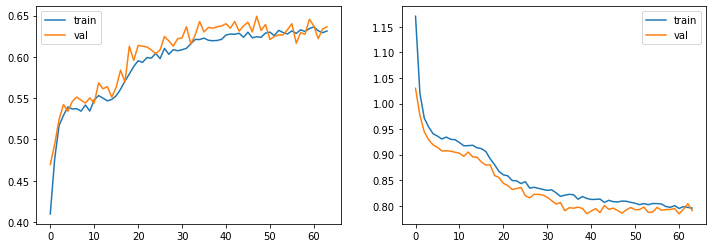

[[262  46 137]
 [ 72 168  32]
 [ 63  51 272]]
Fold 1


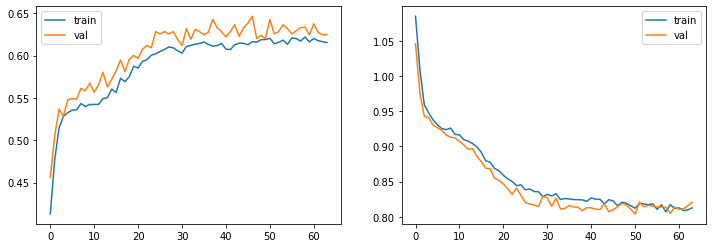

[[258  65 113]
 [ 61 169  51]
 [ 97  27 262]]
Fold 2


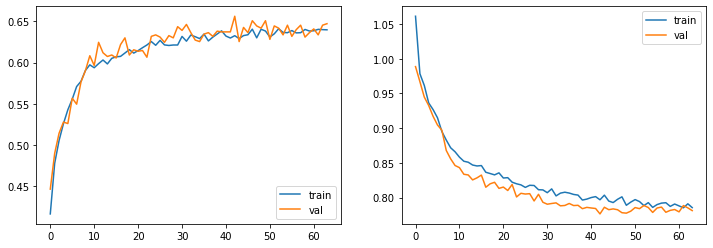

[[271  47 113]
 [ 67 163  57]
 [ 66  39 280]]
Fold 3


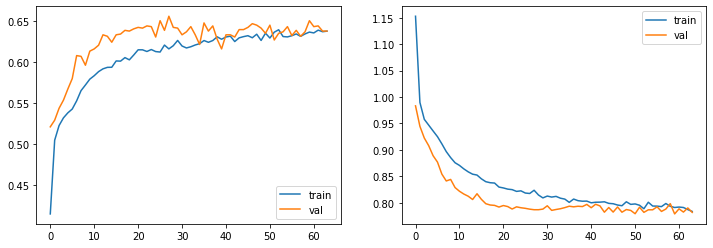

[[259  40 127]
 [ 74 150  61]
 [ 60  37 295]]
Fold 4


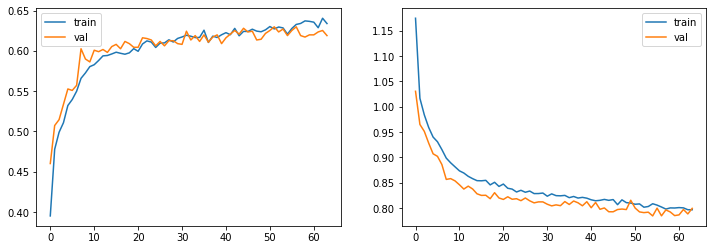

[[202  32 152]
 [ 72 160  59]
 [ 77  28 320]]
[0.7926649332046509, 0.8134065508842468, 0.7827204465866089, 0.7870516538619995, 0.7913600683212281]


In [165]:
models = []
accuracy = []
scores = []

val_model_id = np.zeros(len(train_tensor_field))

# train_tensor_field = train_tensor_field[range(500)]
# labels = labels[range(500)]

kf = KFold(n_splits=5,shuffle=True)
for i,(t,v) in enumerate(kf.split(train_tensor_field,labels)):
    print(f'Fold {i}')
    val_model_id[v] = i
    
    # Assign training and validation data sets
    X_train_raw = train_tensor_field[t]
    y_train_raw = labels[t]
    
    X_val = train_tensor_field[v]
    y_val = labels[v]
    
    # Augment and standardize training data
    X_train, y_train = Augment_Training(X_train_raw,y_train_raw)
    X_train = standardize_features(X_train)
    
    # Standardize validation data
    X_val = standardize_features(X_val)
    
    # Create NN and train
    model_cur = create_NN_field(drop_rate=0.25,learning_rate=0.0008)
    history = model_cur.fit(
        X_train,
        y_train,
        batch_size = 32,
        epochs=64,
        verbose=0,
        validation_data = (X_val,y_val)
    )
    plot_history(history)
    
    # Save models and statistics to appropriate lists
    models.append(model_cur)
    accuracy.append(np.mean(history.history['val_accuracy'][-10:]))
    scores.append(np.mean(history.history['val_loss'][-10:]))
    
    predictions = model_cur.predict(X_val)
    print(tf.math.confusion_matrix(labels=np.argmax(y_val,axis=1), predictions=np.argmax(predictions,axis=1)).numpy())
#     print(tf.math.confusion_matrix(labels=labels, predictions=(model_cur.predict(standardize_features(train_tensor_field))>0.5).astype(int)).numpy())
#     print(tf.math.confusion_matrix(labels=y_val, predictions=(model_cur.predict(X_val)>0.5).astype(int)).numpy())
    
print(scores)

55 54 2970


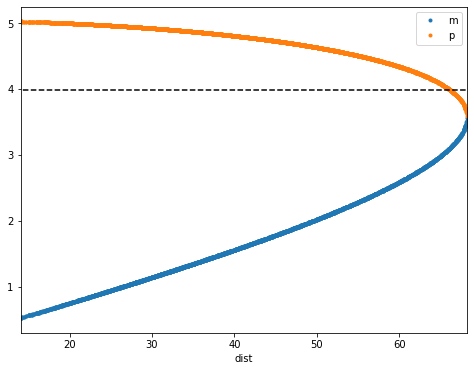

55 54 2856


In [166]:
i=1
bad_ids =[44,61,419,685,917,1077,1903,2681,3126,3603,3609,3788,3825,4156,4418,4421,4567,4569,4663,5044,5224]
check_id = bad_ids[i]

step_size = 1
yardline = fb_x.iloc[check_id,0]

x_yards = np.arange(yardline,110,step_size)
y_yards = np.arange(0,161/3, step_size)

# Create array of new x and y locations for the football to land.
# Zipping expanded_x and expanded_y give all possible locations
expanded_x = x_yards.repeat(len(y_yards))
expanded_y = np.tile(y_yards,len(x_yards))

print(len(x_yards),len(y_yards),len(expanded_x))

def calc_const(dx, dy, ht):
    g = 32.1/3
    dist = np.sqrt(dx**2 + dy**2)
    v_const = (dist/ht)**2 + (g*ht/2)**2
    return np.sqrt(v_const)

def calc_time(del_x, v_const):
    g = 32.1/3
    p1 = 2/g**2*v_const**2
    p2 = 2/g**2*np.sqrt(v_const**4 - g**2 * del_x**2)
    return [np.sqrt(p1-p2),np.sqrt(p1+p2)]


dx = punter.iloc[check_id,0] - fb_x.iloc[check_id,1]
dy = punter.iloc[check_id,1] - fb_y.iloc[check_id,1]
ht = data.iloc[check_id]['hangTime']
v_const = calc_const(dx,dy,ht)

mod_ht = pd.DataFrame(expanded_x,columns=['x'])
mod_ht['y'] = expanded_y
mod_ht['dist'] = np.sqrt((mod_ht['x']-punter.iloc[check_id,0])**2 + (mod_ht['y']-punter.iloc[check_id,1])**2)
mod_ht = mod_ht[mod_ht['dist']<= 3*v_const**2/32.1]
mod_ht['m'],mod_ht['p'] = calc_time(mod_ht['dist'],v_const)

fig,ax=plt.subplots(figsize=(8,6))
mod_ht.plot(x='dist',y='m',ax=ax,style='.')
mod_ht.plot(x='dist',y='p',ax=ax,style='.')
plt.plot(np.array([0,100]),ht*np.ones(2),'k--')
plt.xlim(mod_ht['dist'].min(),mod_ht['dist'].max())
plt.show()

# We have removed the landing locations that are out of range
expanded_x = mod_ht['x'].values
expanded_y = mod_ht['y'].values

print(len(x_yards),len(y_yards),len(expanded_x))

# Keep all the player data from this event the same.
# We only need to change where the ball lands, which only appears in the form (FB_land - P_return)_(x,y)
# Thus, adding the value (FB_land_new - FB_land_old)_(x,y) to the training tensor will update to the new landing position
new_fbland = np.tile(train_tensor_field[check_id],(len(expanded_y),1,1,1)) # Copy play data for each new landing spot

norm_delta_x = expanded_x - fb_x.iloc[check_id,1]
norm_delta_y = expanded_y - fb_y.iloc[check_id,1]

new_fbland[...,4] += np.tile(norm_delta_x[:,np.newaxis,np.newaxis],(1,11,10))
new_fbland[...,5] += np.tile(norm_delta_y[:,np.newaxis,np.newaxis],(1,11,10))
# new_fbland[...,8] = np.tile(expanded_x[:,np.newaxis,np.newaxis],(1,11,10))
# new_fbland[...,9] = np.tile(expanded_x[:,np.newaxis,np.newaxis],(1,11,10))
new_fbland[...,8] = np.tile(mod_ht['p'].values,(10,11,1)).T

model_pred = pd.DataFrame()
for i,model in enumerate(models):
    prob = model.predict(standardize_features(new_fbland))
    potential_land = pd.DataFrame(np.concatenate((np.array([expanded_x,expanded_y]).T,prob),axis=1),columns=['x_land','y_land',f'FC_{i}',f'NF_{i}',f'R_{i}'])
    model_pred = pd.concat([model_pred,potential_land],axis=1)
    
model_pred = model_pred.T.drop_duplicates().T
model_pred['FC_avg'] = model_pred.iloc[:,2::3].mean(axis=1)
model_pred['NF_avg'] = model_pred.iloc[:,3::3].mean(axis=1)
model_pred['R_avg'] = model_pred.iloc[:,4::3].mean(axis=1)

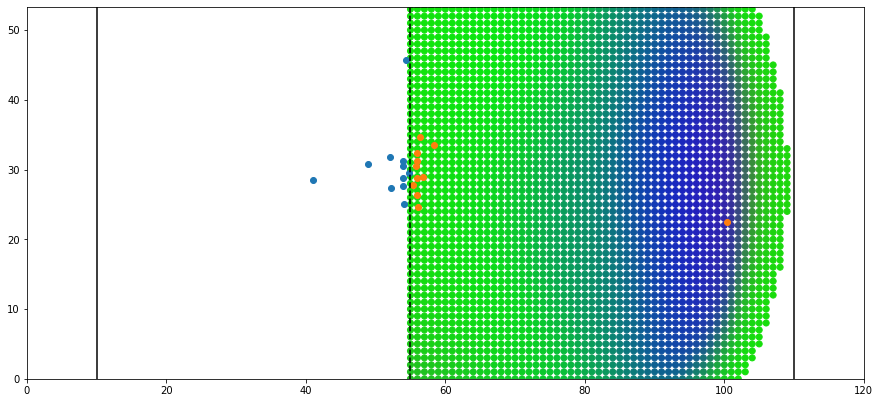

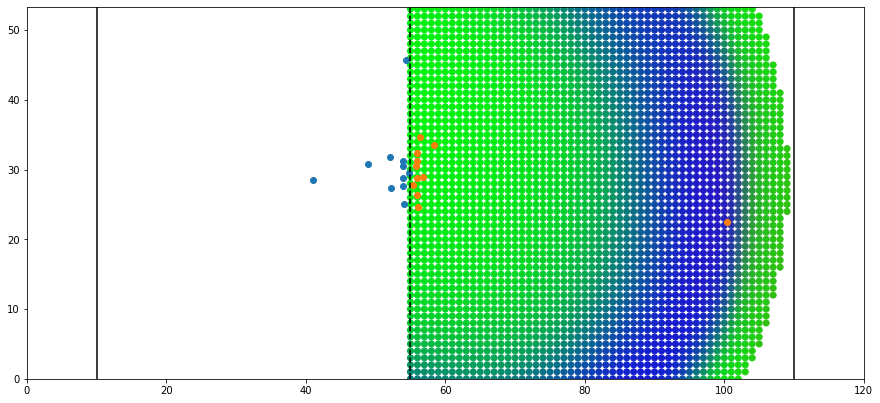

In [167]:
fig,ax = plt.subplots(figsize=(15,10))
ax.scatter(model_pred['x_land'],model_pred['y_land'],c=model_pred[['R_avg','NF_avg','FC_avg']].values)
#model_pred.plot.scatter(x='x_land',y='y_land',c='avg',colormap='BuGn',vmin=0,vmax=1,ax=ax)
plt.scatter(pd.concat([punt_team_x,punter['x_punt']],axis=1).iloc[check_id],pd.concat([punt_team_y,punter['y_punt']],axis=1).iloc[check_id])
plt.scatter(ret_team_x.iloc[check_id],ret_team_y.iloc[check_id])
# #plt.scatter(fb_x[0,0],fb_y[0,0],marker='x')
plt.vlines(x=[10,110],ymin=0,ymax=55,colors='k')
plt.vlines(x=yardline,ymin=0,ymax=55,colors='k',linestyles='dashed')
plt.xlim(0,120)
plt.ylim(0,160/3)
plt.gca().set_aspect(1)
# plt.title('Hang Time: '+str(sample_data['hangTime'].values[0]))
plt.show()


fig,ax = plt.subplots(figsize=(15,10))
ax.scatter(model_pred['x_land'],model_pred['y_land'],c=model_pred[[f'R_{int(val_model_id[check_id])}',f'NF_{int(val_model_id[check_id])}',f'FC_{int(val_model_id[check_id])}']].values)
#model_pred.plot.scatter(x='x_land',y='y_land',c='avg',colormap='BuGn',vmin=0,vmax=1,ax=ax)
plt.scatter(pd.concat([punt_team_x,punter['x_punt']],axis=1).iloc[check_id],pd.concat([punt_team_y,punter['y_punt']],axis=1).iloc[check_id])
plt.scatter(ret_team_x.iloc[check_id],ret_team_y.iloc[check_id])
# #plt.scatter(fb_x[0,0],fb_y[0,0],marker='x')
plt.vlines(x=[10,110],ymin=0,ymax=55,colors='k')
plt.vlines(x=yardline,ymin=0,ymax=55,colors='k',linestyles='dashed')
plt.xlim(0,120)
plt.ylim(0,160/3)
plt.gca().set_aspect(1)
# plt.title('Hang Time: '+str(sample_data['hangTime'].values[0]))
plt.show()

In [240]:
for i, model in enumerate(models):
    model.save(f'./Models/ThreeOutcomeModel{i}.h5')

In [243]:
pd.DataFrame(norm_stats,columns=['mean','std']).to_csv('../ReducedData/training_statistics.csv',index=False)